# 📰 Fake News Detection

##Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout



##Read Dataset

In [ ]:

df_fake = pd.read_csv("Fake.csv", on_bad_lines='skip')
df_real = pd.read_csv("True.csv", on_bad_lines='skip')


df_fake["label"] = 0
df_real["label"] = 1

df = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42).reset_index(drop=True)
df = df[['text', 'label']]
df.dropna(inplace=True)


##Feature Extraction

In [ ]:

from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS

def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)


##Pre-Processing

In [ ]:

X = df['clean_text']
y = df['label']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


##Model Training

In [ ]:

rf = RandomForestClassifier()
nb_model = MultinomialNB()

rf.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
nb_preds = nb_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))


Random Forest Accuracy: 0.9976614699331848
Naive Bayes Accuracy: 0.9418708240534521


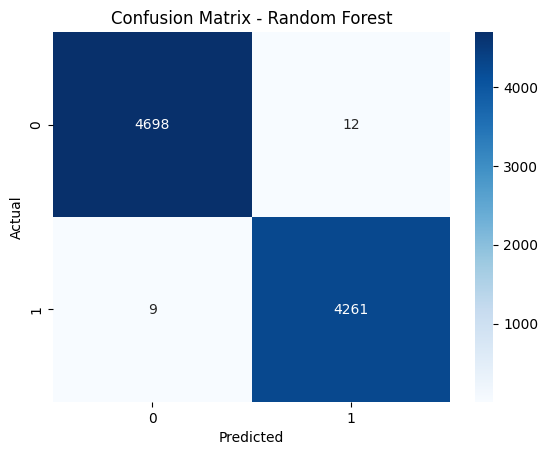

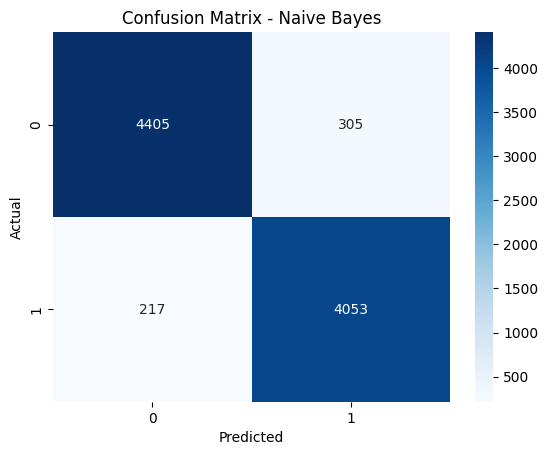

In [ ]:

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, rf_preds, "Random Forest")
plot_conf_matrix(y_test, nb_preds, "Naive Bayes")


In [ ]:
from tensorflow.keras.utils import to_categorical


In [ ]:

max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])

X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)
y_cat = to_categorical(df['label'])

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)


In [ ]:

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_test_seq, y_test_seq))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 281s 489ms/step - accuracy: 0.9032 - loss: 0.2195 - val_accuracy: 0.9849 - val_loss: 0.0531
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 319s 485ms/step - accuracy: 0.9844 - loss: 0.0495 - val_accuracy: 0.9905 - val_loss: 0.0375
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 317s 477ms/step - accuracy: 0.9928 - loss: 0.0243 - val_accuracy: 0.9930 - val_loss: 0.0258


##Evaluate Model

In [18]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"📊 Evaluation Report for {model_name}")
    print("-" * 40)
    print("Accuracy:", round(accuracy_score(y_true, y_pred) * 100, 2), "%")
    print("Precision:", round(precision_score(y_true, y_pred) * 100, 2), "%")
    print("Recall:", round(recall_score(y_true, y_pred) * 100, 2), "%")
    print("F1 Score:", round(f1_score(y_true, y_pred) * 100, 2), "%")
    print("\nDetailed Report:")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))
    print("=" * 40)

# Evaluate Naive Bayes
evaluate_model(y_test, nb_preds, model_name="Naive Bayes")

# Evaluate Random Forest
evaluate_model(y_test, rf_preds, model_name="Random Forest")


# Evaluate LSTM
y_pred_probs = model.predict(X_test_seq)
y_pred_lstm = y_pred_probs.argmax(axis=1)
y_test_labels = y_test_seq.argmax(axis=1)
evaluate_model(y_test_labels, y_pred_lstm, model_name="LSTM")

📊 Evaluation Report for Naive Bayes
----------------------------------------
Accuracy: 94.19 %
Precision: 93.0 %
Recall: 94.92 %
F1 Score: 93.95 %

Detailed Report:
              precision    recall  f1-score   support

        Fake       0.95      0.94      0.94      4710
        Real       0.93      0.95      0.94      4270

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

📊 Evaluation Report for Random Forest
----------------------------------------
Accuracy: 99.77 %
Precision: 99.72 %
Recall: 99.79 %
F1 Score: 99.75 %

Detailed Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4710
        Real       1.00      1.00      1.00      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

281/281 ━━━━━

##Testing Model

In [16]:

def predict_article(text, model_type='rf'):
    clean = preprocess(text)
    if model_type == 'rf':
        vec = tfidf.transform([clean])
        pred = rf.predict(vec)[0]
    elif model_type == 'nb':
        vec = tfidf.transform([clean])
        pred = nb_model.predict(vec)[0]
    elif model_type == 'lstm':
        seq = tokenizer.texts_to_sequences([clean])
        pad_seq = pad_sequences(seq, maxlen=max_len)
        pred = np.argmax(model.predict(pad_seq), axis=1)[0]
    return "Real News" if pred == 1 else "Fake News"

# Example:
article = "The government passed a new law that will affect the economy in 2025."
print("Prediction (Random Forest):", predict_article(article, model_type='rf'))
print("Prediction (Naive Bayes):", predict_article(article, model_type='nb'))
print("Prediction (LSTM):", predict_article(article, model_type='lstm'))


Prediction (Random Forest): Fake News
Prediction (Naive Bayes): Real News
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction (LSTM): Fake News
